# DC-GAN (Deep Convolutional Generative Adversarial Network)

I recently opened Tensorflow's tutorials on GAN (Generative Adversarial Network), and found this [link](https://www.tensorflow.org/tutorials/generative/dcgan). 

Since I still don't make any sense of what I did in TensorLayerX's API, I decided to rewrite the Tensorflow Keras version, in manner of I may be remember and getting to understand it.

In [26]:
import tensorflow;
import matplotlib.pyplot as plt;

## Dataset Loading & Pre-Processing

MNIST dataset is a database of handwritten digits for training. So people will type in 0 to 9 handwrittenly, taking the photo of it, and resizing it to 28 x 28 greyscale pixels.

Tensorflow Keras API had an API to download MNIST dataset, and using it directly as train-test splits. If I'm not mistaken, TensorLayerX also had one, but I prefered this one since I once use it.

By applying `.shape`, we can then see that by default, the training set had 60K worth of data while test set had 10K. From these 10K set, I split the test set into 50:50, making validation set from it.

| Splits | Total data |
|---|---|
| Train | 60000 |
| Test | 5000 |
| Val | 5000 |

In [27]:
from tensorflow.keras.datasets import mnist;
import numpy;
from tensorflow.data import Dataset;

In [28]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data();

# Split the test and val by 50:50
test_val_images_split = numpy.array_split(test_images, 2);
test_val_labels_split = numpy.array_split(test_labels, 2);

test_images = test_val_images_split[0];
test_labels = test_val_labels_split[0];

val_images = test_val_images_split[1];
val_labels = test_val_labels_split[1];

train_images.shape, test_images.shape, val_images.shape

((60000, 28, 28), (5000, 28, 28), (5000, 28, 28))

Honestly I don't really understand why they didn't provide the way we use Test nor Val dataset so, I think I will be exploring it in other time. So here is dataset standard scaler.

In [29]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32');
train_images = (train_images - 127.5) / 127.5;  # Normalize the images to [-1, 1]

## Data Batching Configuration

BUFFER_SIZE means total data within train_images
BATCH_SIZE means the suitable Batch per epoch run. Change as you want.

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
This part will shuffle, and batch out the dataset.

In [30]:


BUFFER_SIZE = train_images.shape[0];
BATCH_SIZE = 256;

BUFFER_SIZE, BATCH_SIZE 

(60000, 256)

In [31]:
train_dataset = Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE);

## Model Architecture

GAN architecture consist of 2 Models. Generator, and Discriminator. 

Generator model inteded to be generate the *fake* hand written. By mean *fake*, means that the model will generate new hand written digit sample. 
Discriminator model intended for telling us whether the generated image are right or not. 

With these information aboves, we can assume that both generator and discriminator model must have at least these architectures as follow:

1. Generator

| Layer type | Specification | Purpose |
|---|---|---|
| Input Layer | Dense -> Shape (100, ) | This contains the random noise data for initializing the weight distribution for the model. |
| Output Layer |  Conv2d -> Shape (28, 28, 1) | The drawing result from the model. |

2. Discriminator

| Layer type | Specification | Purpose |
|---|---|---|
| Input Layer | Conv2d -> Shape (28, 28, 1) | This is must be matched with Generator's output |
| Output Layer | Linear -> Shape (1) | This is boolean. Truthy or falsy. Determine whether the generated image from Generator is fake or not. |

Before we jumping into 

In [32]:
from tensorflow.keras.layers import Input, Conv2DTranspose, Reshape, BatchNormalization, Conv2D, Dense, Flatten;
from tensorflow.keras.layers import LeakyReLU, ReLU;
from tensorflow.keras.models import Sequential;
from tensorflow.keras.initializers import TruncatedNormal;

In [33]:
# G Model

class MNIST_Model_G:
    def __init__(self):
        self.dense1 = Dense(units = 7 * 7 * 256, use_bias = False, name = "dense1", input_shape = (100, ));
        self.bn1 = BatchNormalization(name = "bn1");
        self.act1 = LeakyReLU(name = "act1");

        self.reshape1 = Reshape((7, 7, 256));

        self.convtrans1 = Conv2DTranspose(filters = 128, kernel_size = (5, 5), strides = (1, 1), padding = "same", use_bias = False, name = "convtrans1");
        self.bn2 = BatchNormalization(name = "bn2");
        self.act2 = LeakyReLU(name = "act2");

        self.convtrans2 = Conv2DTranspose(filters = 64, kernel_size = (5, 5), strides = (2, 2), padding = "same", use_bias = False, name = "convtrans2");
        self.bn3 = BatchNormalization(name = "bn3");
        self.act3 = LeakyReLU(name = "act3");

        self.output = Conv2DTranspose(filters = 1, kernel_size = (5, 5), strides = (2, 2), padding = "same", use_bias = False, name = "output");

    def build_model(self):
        model = Sequential(name = "MNIST_Model_G.202405081658");
        
        model.add(self.dense1);
        model.add(self.bn1);
        model.add(self.act1);

        model.add(self.reshape1);

        model.add(self.convtrans1);
        model.add(self.bn2);
        model.add(self.act2);

        model.add(self.convtrans2);
        model.add(self.bn3);
        model.add(self.act3);

        model.add(self.output);

        return model;

In [34]:
mnist_G = MNIST_Model_G();
generator = mnist_G.build_model();

c:\Users\yosua\anaconda3\envs\tlx\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


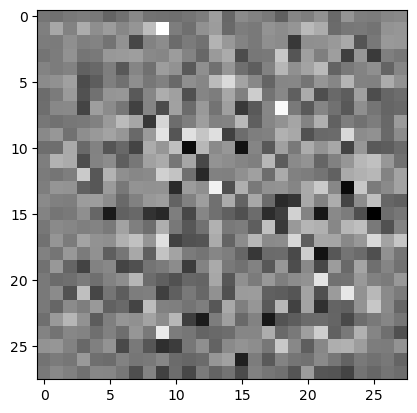

In [35]:
# Test noise
noise = tensorflow.random.normal([1, 100]);

generated_image = generator(noise, training = False);

plt.imshow(generated_image[0, :, :, 0], cmap = "gray")


In [36]:
# D Model

class MNIST_Model_D():
    def __init__(self):
        self.input = Input(shape = (28, 28, 1));

        self.conv1 = Conv2D(filters = 64, kernel_size = (5, 5), strides = (2, 2), padding = "same");
        self.act1 = LeakyReLU(name = "act1");

        self.conv2 = Conv2D(filters = 128, kernel_size = (5, 5), strides = (2, 2), padding = "same");
        self.act2 = LeakyReLU(name = "act2");

        self.flat = Flatten(name = "flat");
        self.output = Dense(units = 1);

    def build_model(self):
        model = Sequential(name = "MNIST_Model_D.202405081658");
        model.add(self.input);

        model.add(self.conv1);
        model.add(self.act1);

        model.add(self.conv2);
        model.add(self.act2);

        model.add(self.flat);
        model.add(self.output);

        return model;

In [37]:
discriminator = MNIST_Model_D().build_model();

decision = discriminator(generated_image);
print (decision);

tf.Tensor([[0.49996242]], shape=(1, 1), dtype=float32)


## Defining Discriminator Loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [38]:
from tensorflow.keras.losses import BinaryCrossentropy;
from tensorflow import ones_like;

In [39]:
binary_cross_entropy = BinaryCrossentropy(from_logits = True);

def discriminator_loss(real_output, fake_output):
    real_loss = binary_cross_entropy(ones_like(real_output), real_output);
    fake_loss = binary_cross_entropy(ones_like(fake_output), fake_output); 

    total_loss = real_loss + fake_loss;
    return total_loss;

## Defining Generator Loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [40]:
def generator_loss(fake_output):
    return binary_cross_entropy(ones_like(fake_output), fake_output);

## Gradient Descent Optimization

This part defining gradient descent for both Generator and Discriminator

In [41]:
from keras.optimizers import Adam;

In [42]:
G_optim = Adam(learning_rate = 1e-3);
D_optim = Adam(learning_rate = 1e-3);

## Model Training Checkpoint

In [43]:
import os;
import tensorflow;

checkpoint_dir = './training_checkpoints';
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tensorflow.train.Checkpoint(
    generator_optimizer = G_optim,
    discriminator_optimizer = D_optim,
    generator = generator,
    discriminator = discriminator
);

## Adversarial Training Session

The special of GAN is the adversarial training process. While you train Discriminator like wise, the Generator model's backpropagation, is very dependent on the Discriminator's judgement. The logits that being generated by generator will be determined by its value whether the *wrong fake image* was spotted. This made GAN model cannot be trained using framework-wise like `fit` function in Tensorflow. This method is called as "Train One Step".

In [44]:
# Training Session Configuration
EPOCHS = 300;
noise_dimension = 100;
sample_to_be_generated = 16;

seed = tensorflow.random.normal([sample_to_be_generated, noise_dimension]);

The training loop begins with generator receiving a random seed as input that was earlier called *noise*. That seed or *noise* is used to produce an image. 

The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [45]:
from tensorflow import GradientTape;

In [46]:
# This function needs to be compiled first before can be used.
@tensorflow.function
def train_one_step(image):
    noise = tensorflow.random.normal([BATCH_SIZE, noise_dimension]);

    with GradientTape() as generator_tape, GradientTape() as discriminator_tape:

        # Generator model generate an image with loaded noise
        generated_image = generator(noise, training = True);

        # Getting the "real" logits
        real_output = discriminator(image, training = True);
        
        # Getting the "fake" logits
        fake_output = discriminator(generated_image, training = True);

        # Output loss
        G_loss = generator_loss(fake_output = fake_output);
        D_loss = discriminator_loss(real_output = real_output, fake_output = fake_output);

    # Define weight 
    G_weight = generator_tape.gradient(G_loss, generator.trainable_weights);
    D_weight = discriminator_tape.gradient(D_loss, discriminator.trainable_weights);
    
    G_optim.apply_gradients(zip(G_weight, generator.trainable_weights));
    D_optim.apply_gradients(zip(D_weight, discriminator.trainable_weights));
    

In [47]:
# Progress bar
from tqdm import tqdm;
from time import time;

In [48]:
# Plot the testing 
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training = False);

    plt.figure(figsize=(4, 4));

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1);
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray');
        plt.axis('off');

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch));
    plt.show();

In [49]:
def train (dataset):
    for i in range(EPOCHS):
        start_time = time();

        print(f"Training Epoch {i + 1} / {EPOCHS}", end = " ");

        for X_batch in tqdm(dataset):
            train_one_step(X_batch);

    # Produce Image for the GIF as you go
    display.clear_output(wait = True);
    generate_and_save_images(
        generator,
        EPOCHS,
        seed
    ); 

## Start Adversarial Training

In [50]:
train(train_dataset);

Training Epoch 1 / 300 

  0%|          | 0/235 [00:00<?, ?it/s]c:\Users\yosua\anaconda3\envs\tlx\Lib\site-packages\keras\src\backend\tensorflow\nn.py:695: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 37%|███▋      | 86/235 [00:32<00:56,  2.64it/s]


KeyboardInterrupt: 

In [ ]:
checkpoint.restore(tensorflow.train.latest_checkpoint(checkpoint_dir));

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS);

## Make training progress GIF using image.io

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png');
    filenames = sorted(filenames);
    for filename in filenames:
        image = imageio.imread(filename);
        writer.append_data(image);
    image = imageio.imread(filename);
    writer.append_data(image);

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file);